In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import torch

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from time import time
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [3]:
# Conversione in un formato utile a BERT
resumes = df["Resume_str"].tolist()
labels = df["Category"].astype("category").cat.codes

In [4]:
X_train, X_test, y_train, y_test = train_test_split(resumes, labels, test_size=0.2, random_state=42)

In [5]:
# Caricamento tokenizer e modello BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\andre\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
# Funzione per ottenere l'embedding del CLS token
def get_bert_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [7]:
X_train_embed = np.array([get_bert_embedding(text) for text in tqdm(X_train)])
X_test_embed = np.array([get_bert_embedding(text) for text in tqdm(X_test)])

100%|██████████| 497/497 [05:02<00:00,  1.64it/s]


In [8]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max() * 0.8)
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [9]:
X_train_resampled, y_train_resampled = smote(X_train_embed, y_train.reset_index(drop=True))

Applicazione di SMOTE alle classi: [2, 5, 8] 



### Random Forest Classifier

In [10]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [11]:
skf = StratifiedKFold(n_splits=5)

In [12]:
#'''
RFC = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [400, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [8,9,10],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=skf, scoring='accuracy', return_train_score=False, verbose=3, n_jobs=-1)

start = time()
grid_search = grid.fit(X_train_resampled, y_train_resampled)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_) 
#'''

Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV took 1402.70 seconds for 24 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.493 (std: 0.024)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 700}

Model with rank: 2
Mean validation score: 0.492 (std: 0.023)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 400}

Model with rank: 3
Mean validation score: 0.490 (std: 0.015)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 700}

Model with rank: 4
Mean validation score: 0.489 (std: 0.020)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 700}

Model with rank: 5
Mean validation score: 0.488 (std: 0.024)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 700}

Model with rank: 6
Mean validation score: 0.488 (std: 0.024)
Paramete

In [13]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 700}


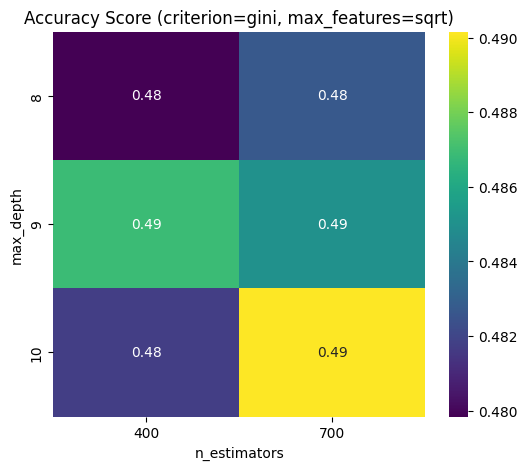

In [14]:
# '''
results = pd.DataFrame(grid_search.cv_results_)

filtered = results[
    (results['param_criterion'] == 'gini') & 
    (results['param_max_features'] == 'sqrt')
]

pvt = filtered.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)
plt.title('Accuracy Score (criterion=gini, max_features=sqrt)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()
# '''

In [15]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test_embed)

In [16]:
# RF_Model_best = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 700, max_depth=10, criterion='gini')
# RF_Model_best.fit(X_train_resampled, y_train_resampled)

In [17]:
# prediction = RF_Model_best.predict(X_test_features)

In [18]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_embed, y_test)))

Training Score: 1.00
Test Score: 0.48


In [19]:

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70        28
           1       0.22      0.07      0.10        30
           2       0.17      0.10      0.12        10
           3       0.57      0.57      0.57        14
           4       0.25      0.11      0.15        18
           5       0.00      0.00      0.00         5
           6       0.69      0.83      0.75        24
           7       0.33      0.38      0.35        16
           8       0.00      0.00      0.00         3
           9       0.41      0.52      0.46        23
          10       0.68      0.81      0.74        31
          11       0.88      0.69      0.77        32
          12       0.00      0.00      0.00        23
          13       0.59      0.53      0.56        19
          14       0.78      0.32      0.45        22
          15       0.36      0.64      0.46        14
          16       0.41      0.28      0.33        25
          17       0.55    

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Figure size 1500x1000 with 0 Axes>

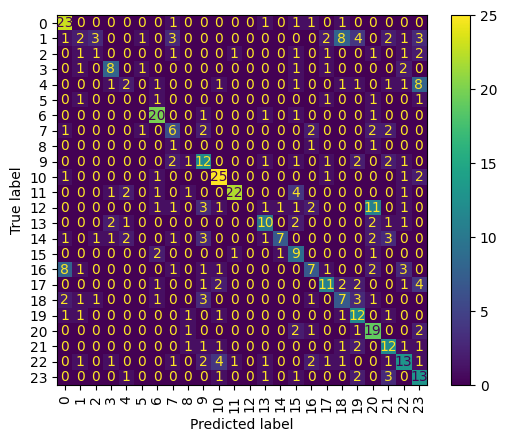

In [20]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()